# Linear Regression

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like [linear regression](https://en.wikipedia.org/wiki/Linear_regression). This tutorial covers how to implement a linear regression model in Turing.

## Set Up

We begin by importing all the necessary libraries.

In [1]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(0);

# Hide the progress prompt while sampling.
Turing.turnprogress(false);

loaded


┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/cameron/.julia/dev/Turing/src/Turing.jl:24


We will use the `mtcars` dataset from the [RDatasets](https://github.com/johnmyleswhite/RDatasets.jl) package. `mtcars` contains a variety of statistics on different car models, including their miles per gallon, number of cylinders, and horsepower, among others.

We want to know if we can construct a Bayesian linear regression model to predict the miles per gallon of a car, given the other statistics it has. Lets take a look at the data we have.

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS,AM,Gear,Carb
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0,1,4,4
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0,1,4,4
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1,1,4,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0,0,3,2
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1,0,3,1


In [3]:
size(data)

(32, 12)

The next step is to get our data ready for testing. We'll split the `mtcars` dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (`MPG`, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called `unstandardize`, which returns the standardized values to their original form. We will use this function later on when we make predictions.

In [4]:
# Function to split samples.
function split_data(df, at = 0.70)
    (r, _) = size(df)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(data, 0.7)

# Save dataframe versions of our dataset.
train_cut = DataFrame(train)
test_cut = DataFrame(test)

# Create our labels. These are the values we are trying to predict.
train_label = train[:, :MPG]
test_label = test[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

# Filter the test and train sets.
train = Matrix(train[:,remove_names]);
test = Matrix(test[:,remove_names]);

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

# Standardize our dataset.
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

## Model Specification

In a traditional frequentist model using [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares), our model might look like:

$$
MPG_i = \alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}
$$

where $\boldsymbol{\beta}$ is a vector of coefficients and $\boldsymbol{X}$ is a vector of inputs for observation $i$. The Bayesian model we are more concerned with is the following:

$$
MPG_i \sim \mathcal{N}(\alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}, \sigma^2)
$$

where $\alpha$ is an intercept term common to all observations, $\boldsymbol{\beta}$ is a coefficient vector, $\boldsymbol{X_i}$ is the observed data for car $i$, and $\sigma^2$ is a common variance term.

For $\sigma^2$, we assign a prior of `TruncatedNormal(0,100,0,Inf)`. This is consistent with [Andrew Gelman's recommendations](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf) on noninformative priors for variance. The intercept term ($\alpha$) is assumed to be normally distributed with a mean of zero and a variance of three. This represents our assumptions that miles per gallon can be explained mostly by our assorted variables, but a high variance term indicates our uncertainty about that. Each coefficient is assumed to be normally distributed with a mean of zero and a variance of 10. We do not know that our coefficients are different from zero, and we don't know which ones are likely to be the most important, so the variance term is quite high. Lastly, each observation $y_i$ is distributed according to the calculated `mu` term given by $\alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}$.

In [5]:
# Bayesian linear regression.
@model linear_regression(x, y, n_obs, n_vars) = begin
    # Set variance prior.
    σ₂ ~ TruncatedNormal(0,100, 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, 3)
    
    # Set the priors on our coefficients.
    coefficients = Array{Real}(undef, n_vars)
    coefficients ~ [Normal(0, 10)]
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    for i = 1:n_obs
        y[i] ~ Normal(mu[i], σ₂)
    end
end;

With our model specified, we can call the sampler. We will use the No U-Turn Sampler ([NUTS](http://turing.ml/docs/library/#-turingnuts--type)) here. 

In [6]:
n_obs, n_vars = size(train)
model = linear_regression(train, train_label, n_obs, n_vars)
chain = sample(model, NUTS(1500, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/cameron/.julia/dev/Turing/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.ForwardDiffAD{40},Union{}}] found initial ϵ: 0.4
└ @ Turing.Inference /home/cameron/.julia/dev/Turing/src/inference/support/hmc_core.jl:235
┌ Info:  Adapted ϵ = 0.043869934410525904, std = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/cameron/.julia/dev/Turing/src/inference/adapt/adapt.jl:91


[NUTS] Finished with
  Running time        = 35.317116096999946;
  #lf / sample        = 0.0;
  #evals / sample     = 96.34133333333334;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


As a visual check to confirm that our coefficients have converged, we show the densities and trace plots for our parameters using the `plot` functionality.

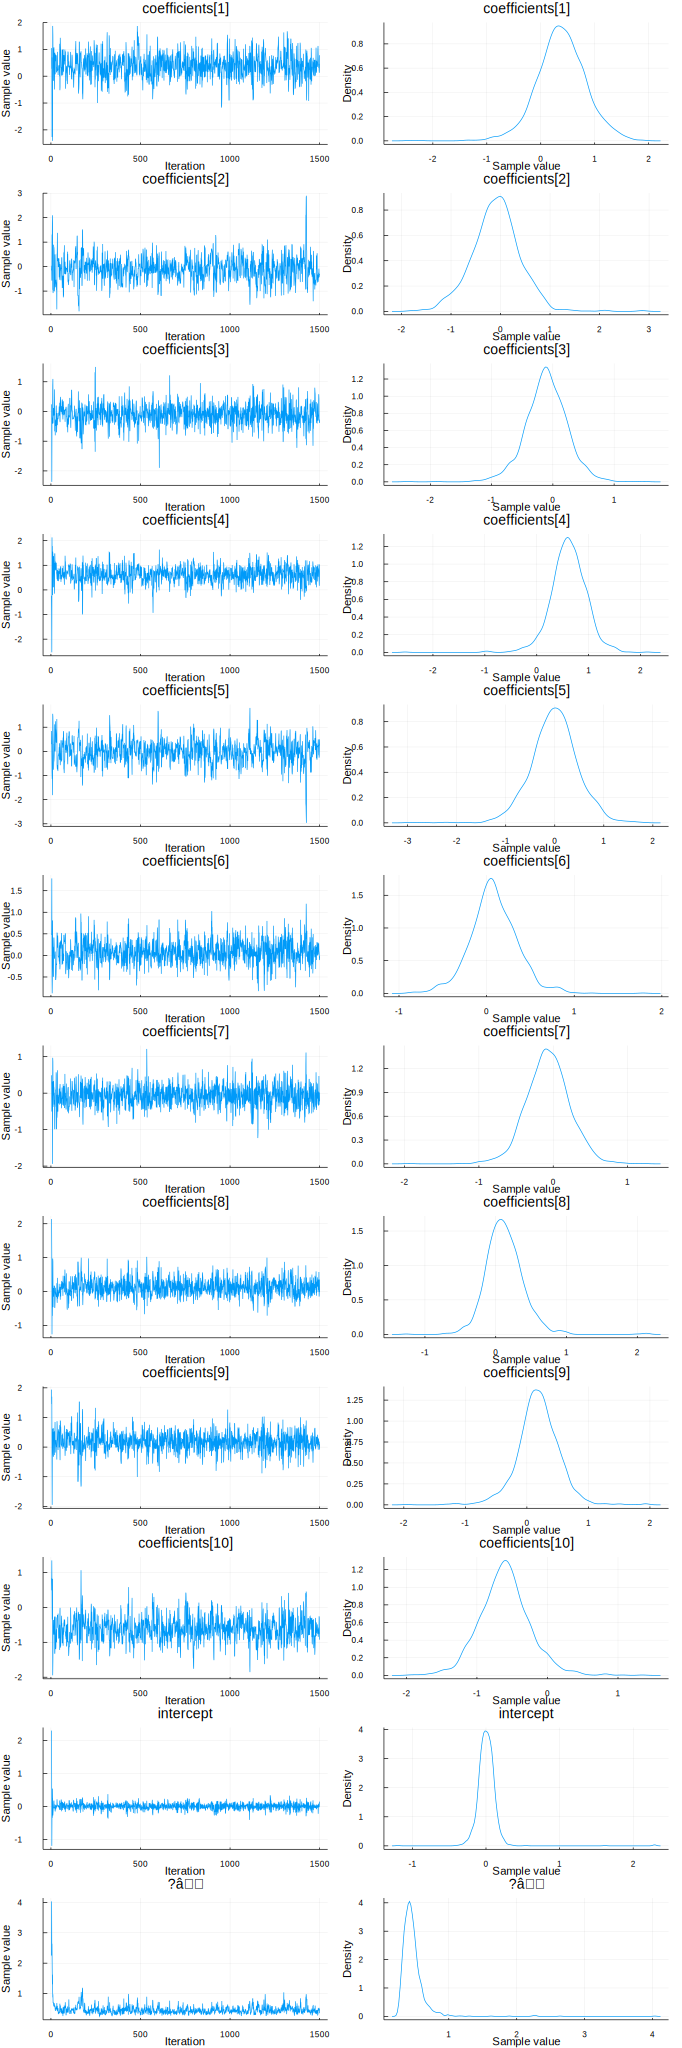

In [7]:
plot(chain)

It looks like each of our parameters has converged. We can check our numerical esimates using `describe(chain)`, as below.

In [8]:
describe(chain)

Iterations = 1:1500
Thinning interval = 1
Chains = 1
Samples per chain = 1500

Empirical Posterior Estimates:
                      Mean          SD        Naive SE       MCSE         ESS   
          lf_num   0.000000000  0.000000000 0.0000000000 0.0000000000        NaN
 coefficients[7]  -0.069379087  0.297111820 0.0076713942 0.0062666679 1500.00000
 coefficients[9]   0.183295384  0.346104116 0.0089363699 0.0121530202  811.04526
              σ₂   0.469602793  0.193836072 0.0050048259 0.0163021444  141.37731
 coefficients[8]   0.126314007  0.272189289 0.0070278972 0.0043142310 1500.00000
 coefficients[4]   0.614135907  0.344119004 0.0088851145 0.0120624748  813.85021
 coefficients[1]   0.382941674  0.457696592 0.0118176752 0.0156500086  855.31521
       intercept   0.008082493  0.151973153 0.0039239299 0.0066216748  526.74212
         elapsed   0.055221650  0.172942538 0.0044653571 0.0054206781 1017.87964
         epsilon   0.047158347  0.038086234 0.0009833823 0.0022651873  282.70133

## Comparing to OLS

A satisfactory test of our model is to evaluate how well it predicts. Importantly, we want to compare our model to existing tools like OLS. The code below uses the [GLM.jl]() package to generate a traditional OLS multivariate regression on the same data as our probabalistic model.

In [9]:
# Import the GLM package.
using GLM

# Perform multivariate OLS.
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

# Store our predictions in the original dataframe.
train_cut.OLSPrediction = GLM.predict(ols);
test_cut.OLSPrediction = GLM.predict(ols, test_cut);

The function below accepts a chain and an input matrix and calculates predictions. We use the mean observation of each parameter in the model starting with sample 200, which is where the warm-up period for the NUTS sampler ended.

In [10]:
# Make a prediction given an input vector.
function prediction(chain, x)
    α = chain[:intercept][200:end]
    β = chain[:coefficients][200:end]
    return  mean(α) .+ x * mean(β)
end

prediction (generic function with 1 method)

When we make predictions, we unstandardize them so they're more understandable. We also add them to the original dataframes so they can be placed in context.

In [11]:
# Calculate the predictions for the training and testing sets.
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

# Show the first side rows of the modified dataframe.
first(test_cut, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS,AM,Gear,Carb,OLSPrediction,BayesPredictions
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64
1,AMC Javelin,15.2,8,304.0,150,3.15,3.435,17.3,0,0,3,2,19.8583,17.2538
2,Camaro Z28,13.3,8,350.0,245,3.73,3.84,15.41,0,0,3,4,16.0462,17.2745
3,Pontiac Firebird,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2,18.5746,16.0018
4,Fiat X1-9,27.3,4,79.0,66,4.08,1.935,18.9,1,1,4,1,29.3233,25.8621
5,Porsche 914-2,26.0,4,120.3,91,4.43,2.14,16.7,0,1,5,2,30.7731,27.9732
6,Lotus Europa,30.4,4,95.1,113,3.77,1.513,16.9,1,1,5,2,25.2892,21.8802


Now let's evaluate the loss for each method, and each prediction set. We will use sum of squared error function to evaluate loss, given by 

$$
\text{SSE} = \sum{(y_i - \hat{y_i})^2}
$$

where $y_i$ is the actual value (true MPG) and $\hat{y_i}$ is the predicted value using either OLS or Bayesian linear regression. A lower SSE indicates a closer fit to the data.

In [12]:
bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.MPG).^2)

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    Bayes loss: $bayes_loss1
    OLS loss: $ols_loss1
Test set: 
    Bayes loss: $bayes_loss2
    OLS loss: $ols_loss2")

Training set:
    Bayes loss: 67.62926048530228
    OLS loss: 67.56037474764624
Test set: 
    Bayes loss: 213.08154799539776
    OLS loss: 270.94813070761944


As we can see above, OLS and our Bayesian model fit our training set about the same. This is to be expected, given that it is our training set. But when we look at our test set, we see that the Bayesian linear regression model is better able to predict out of sample.